In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dateutil import parser
import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import Counter
from openpyxl import Workbook
import warnings
warnings.filterwarnings("ignore") 

In [2]:
base_url = f"https://www.airlinequality.com/airline-reviews/british-airways"
pagesize = 100
pages = 45
airline = f"BA"
region = f"Europe"

In [3]:
# Create an empty DataFrame
db = pd.DataFrame(columns=['Customer Name', 'Traveller','Seat type','Region','Date', 'Airline', 'Title', 'Rating', 'Date Flown', 'Recommended', 'Review'])

for i in range(1, pages+1):
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={pagesize}"
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')

    for div in soup.find_all("article", itemprop="review"):
        
        rating = div.find("span", itemprop="ratingValue")
        rating = rating.text if rating else "N/A"
        
        customer = div.find("span", itemprop="name")
        customer = customer.text if rating else "N/A"
        
        title = div.find("h2", class_="text_header").get_text().strip('"')
        
        date = div.find("time", itemprop="datePublished")
        if date:
            date = parser.parse(date.text)
            date = date.strftime('%Y-%m-%d')
        else:
            date = "N/A"
        
        review = div.find("div", class_="text_content").get_text().strip('✅')
       
        tr = div.find("td", class_="review-rating-header type_of_traveller")
        if tr:
            tr = tr.find_parent("tr")
            traveller = tr.find("td", class_=("review-value"))
            traveller = traveller.text if traveller else "N/A"
        else:
            traveller = "N/A"
            
            
        tr = div.find("td", class_="review-rating-header cabin_flown")
        if tr:
            tr = tr.find_parent("tr")
            seat = tr.find("td", class_=("review-value"))
            seat = seat.text if seat else "N/A"
        else:
            seat = "N/A"
        
        tr = div.find("td", text="Date Flown")
        if tr:
            tr = tr.find_parent("tr")
            date_flown = tr.find("td", class_="review-value")
            date_flown = date_flown.text if date_flown else "N/A"
            if date_flown:
                date_flown = parser.parse(date_flown)
                date_flown = date_flown.strftime('%Y-%m-%d')
            else:
                date_flown = "N/A"
        else:
            date_flown = "N/A"

            
        tr = div.find("td", class_="review-rating-header recommended")
        if tr:
            tr = tr.find_parent("tr")
            recommended = tr.find("td", class_=lambda x: x and x.startswith("review-value rating-"))
            recommended = recommended.text if recommended else "N/A"
        else:
            recommended = "N/A"
        # Append the data to the DataFrame

        db_new_row = pd.DataFrame({'Customer Name':[customer],'Traveller':[traveller],'Seat type':[seat],'Region': [region],'Airline': [airline],'Rating': [rating], 'Title': [title], 'Date': [date], 'Review': [review], 'Date Flown': [date_flown], 'Recommended': [recommended]})
        db = pd.concat([db, db_new_row])

db.head(3)

,Customer Name,Traveller,Seat type,Region,Date,Airline,Title,Rating,Date Flown,Recommended,Review
0,P Cooper,Solo Leisure,Business Class,Europe,2023-09-23,BA,"never fly this awful airline again""",1,2023-08-27,no,"Trip Verified | I had a flight from Miami, Fl..."
0,Bruce Friedman,Business,Business Class,Europe,2023-09-22,BA,I’ll never fly with them again,1,2023-09-27,no,Trip Verified | We started our day with BA i...
0,R Barton,Business,Economy Class,Europe,2023-09-22,BA,the worst of the worst,1,2023-09-27,no,Trip Verified | I fly British Airways weekly...


In [5]:
#Saving data into a csv
db.to_csv(r'C:\Users\dark voltaire\Desktop\DATA PROJECTS\british airways\BA_reviews.csv')

In [6]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657 entries, 0 to 0
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer Name  3657 non-null   object
 1   Traveller      3657 non-null   object
 2   Seat type      3657 non-null   object
 3   Region         3657 non-null   object
 4   Date           3657 non-null   object
 5   Airline        3657 non-null   object
 6   Title          3657 non-null   object
 7   Rating         3657 non-null   object
 8   Date Flown     3657 non-null   object
 9   Recommended    3657 non-null   object
 10  Review         3657 non-null   object
dtypes: object(11)
memory usage: 342.8+ KB


In [7]:
# Creating a new column called 'SENTIMENT' that contains the sentiment scores of each review using nltk
from nltk.sentiment import vader
import nltk
import matplotlib.pyplot as plt

In [8]:
# Read in the reviews data from a CSV file
sa_df = pd.read_csv(r'C:\Users\dark voltaire\Desktop\DATA PROJECTS\british airways\BA_reviews.csv')

In [9]:
# an instance of SentimentIntensityAnalyzer
s_a = vader.SentimentIntensityAnalyzer()

# a new column named 'SENTIMENT'
sa_df['Sentiment'] = sa_df['Review'].apply(
    lambda review: s_a.polarity_scores(review)['compound']
    )
sa_df.head(4)

,Unnamed: 0,Customer Name,Traveller,Seat type,Region,Date,Airline,Title,Rating,Date Flown,Recommended,Review,Sentiment
0,0,P Cooper,Solo Leisure,Business Class,Europe,2023-09-23,BA,"never fly this awful airline again""",1.0,2023-08-27,no,"Trip Verified | I had a flight from Miami, Fl...",-0.8689
1,0,Bruce Friedman,Business,Business Class,Europe,2023-09-22,BA,I’ll never fly with them again,1.0,2023-09-27,no,Trip Verified | We started our day with BA i...,-0.9755
2,0,R Barton,Business,Economy Class,Europe,2023-09-22,BA,the worst of the worst,1.0,2023-09-27,no,Trip Verified | I fly British Airways weekly...,-0.9580
3,0,Terri Galli,Family Leisure,Economy Class,Europe,2023-09-20,BA,"everyone refused to help us""",1.0,2023-08-27,no,Not Verified | Everything was ok until our co...,-0.9348


In [10]:
# Creating another new column called 'SENTIMENT_TYPE' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'SENTIMENT' column
sa_df['Sentiment_type'] = sa_df['Sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
sa_df.head(5)

,Unnamed: 0,Customer Name,Traveller,Seat type,Region,Date,Airline,Title,Rating,Date Flown,Recommended,Review,Sentiment,Sentiment_type
0,0,P Cooper,Solo Leisure,Business Class,Europe,2023-09-23,BA,"never fly this awful airline again""",1.0,2023-08-27,no,"Trip Verified | I had a flight from Miami, Fl...",-0.8689,negative
1,0,Bruce Friedman,Business,Business Class,Europe,2023-09-22,BA,I’ll never fly with them again,1.0,2023-09-27,no,Trip Verified | We started our day with BA i...,-0.9755,negative
2,0,R Barton,Business,Economy Class,Europe,2023-09-22,BA,the worst of the worst,1.0,2023-09-27,no,Trip Verified | I fly British Airways weekly...,-0.9580,negative
3,0,Terri Galli,Family Leisure,Economy Class,Europe,2023-09-20,BA,"everyone refused to help us""",1.0,2023-08-27,no,Not Verified | Everything was ok until our co...,-0.9348,negative
4,0,Selcuk Benter,Business,Premium Economy,Europe,2023-09-20,BA,not a single feedback from British Airways,1.0,2023-08-27,no,Not Verified | My initial flight was cancelle...,-0.8481,negative


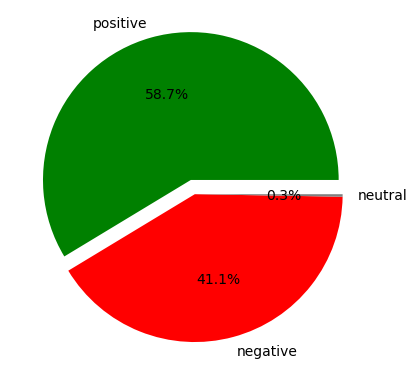

In [11]:
# calculate the percentage of each type of sentiment score
sentiment_type_percentages = sa_df['Sentiment_type'].value_counts(normalize=True) * 100

# create the pie chart
fig, ax = plt.subplots()
ax.pie(
    sentiment_type_percentages,
    labels=sentiment_type_percentages.index, 
    colors=['green', 'red', 'grey'], 
    explode=[0.1, 0, 0], 
    autopct='%1.1f%%'
    )

plt.show()

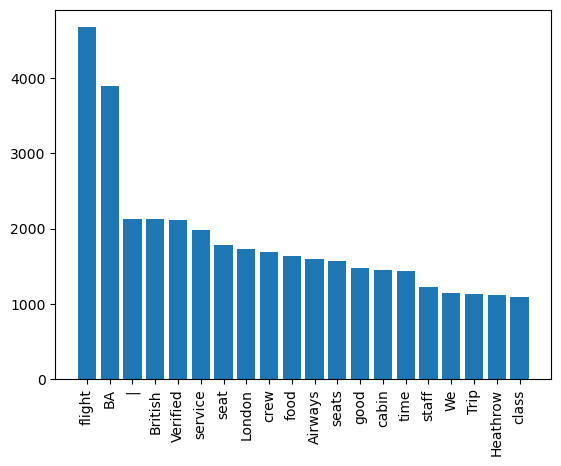

In [12]:
# The frequency chart shows the key topics within the 
# reviews showing what people are actively talking about their experience and staff

# Get the reviews from the dataframe
reviews = sa_df['Review']

# Convert the reviews to a list of words
words = []
for review in reviews:
    words.extend(review.split())

# Filter out the stubborn stop words that don't want to disappear
stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]

# Get the top 20 most used key words
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out the stop words 
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]

# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()


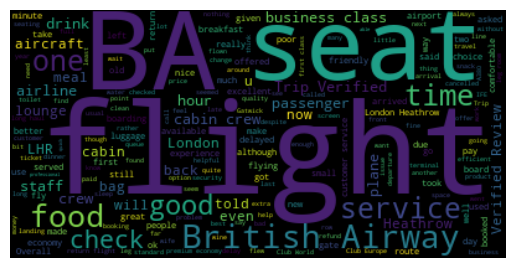

In [13]:
# Import the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Create the wordcloud
wordcloud = WordCloud(random_state=42).generate(' '.join(sa_df['Review']))

# Show the word cloud
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()